# LXMERT
- Author: Sungguk Cha
- Date: Jun 3rd, 2021

## Dependencies

In [1]:
import sys
import time

sys.path.append("../src")

from modeling_frcnn import GeneralizedRCNN
from processing_image import Preprocess
import utils

import cv2
from matplotlib import pyplot as plt
from PIL import Image
import torch
from transformers import LxmertForQuestionAnswering, LxmertTokenizer

## Load models

In [2]:
frcnn_cfg = utils.Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

image_preprocess = Preprocess(frcnn_cfg)

lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")
lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased")

VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"
vqa_answers = utils.get_data(VQA_URL)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /root/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


## Test

In [9]:
def inference(image, questions):
    with torch.no_grad():
        images, sizes, scales_yx = image_preprocess(image)

        output_dict = frcnn(
            images, 
            sizes, 
            scales_yx = scales_yx, 
            padding = 'max_detections', 
            max_detections = frcnn_cfg.max_detections, 
            return_tensors = 'pt'
        )

        normalized_boxes = output_dict.get("normalized_boxes")
        features = output_dict.get("roi_features")

        inputs = lxmert_tokenizer(
            questions,
            padding="max_length",
            max_length=20,
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        output_vqa = lxmert_vqa(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            visual_feats=features,
            visual_pos=normalized_boxes,
            token_type_ids=inputs.token_type_ids,
            return_dict=True,
            output_attentions=False,
        )

        #pred_vqa = output_vqa["question_answering_score"].argmax(-1)
        #print("Question:", questions)
        #print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])
        return output_vqa

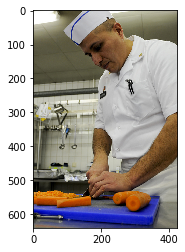

In [4]:
image_dir = "../sample/sample.jpg"
image = Image.open(image_dir)
image_cv2 = cv2.imread(image_dir)
plt.imshow(image)
plt.show()

In [11]:
questions = ["Which vegetable is there?", "what is the job of the person?", "how many pieces of carrots are there?"]
output_vqa = inference(image_cv2, questions)

In [17]:
pred_vqa = output_vqa["question_answering_score"].argmax(-1)
result = list()
for pred in pred_vqa:
    result.append(vqa_answers[pred])
print(result)

['carrot', 'chef', '2']
